In [17]:
import numpy as np
import cv2 as cv
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


In [20]:
class GMM:
    def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
        self.ncomp = ncomp
        self.mus = np.asarray(initial_mus)
        self.covs = np.asarray(initial_covs)
        self.priors = np.asarray(initial_priors)

    def inference(self, datas): # E-step
        unnormalized_probs = []
        for i in range(self.ncomp):
            mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i]
            unnormalized_prob = prior * multivariate_normal.pdf(datas, mean=mu, cov=cov)
            unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
        preds = np.concatenate(unnormalized_probs, axis=1)
        log_likelihood = np.sum(preds, axis=1)
        log_likelihood = np.sum(np.log(log_likelihood))

        preds = preds / np.sum(preds, axis=1, keepdims=True)
        return np.asarray(preds), log_likelihood

    def update(self, datas, beliefs): # M-step
        new_mus, new_covs, new_priors = [], [], []
        soft_counts = np.sum(beliefs, axis=0)
        for i in range(self.ncomp):
            new_mu = np.sum(np.expand_dims(beliefs[:, i], -1) * datas, axis=0)
            new_mu /= soft_counts[i]
            new_mus.append(new_mu)

            data_shifted = np.subtract(datas, np.expand_dims(new_mu, 0))
            new_cov = np.matmul(np.transpose(np.multiply(np.expand_dims(beliefs[:, i], -1), data_shifted)), data_shifted)
            new_cov /= soft_counts[i]
            new_covs.append(new_cov)

            new_priors.append(soft_counts[i] / np.sum(soft_counts))

        self.mus = np.asarray(new_mus)
        self.covs = np.asarray(new_covs)
        self.priors = np.asarray(new_priors)


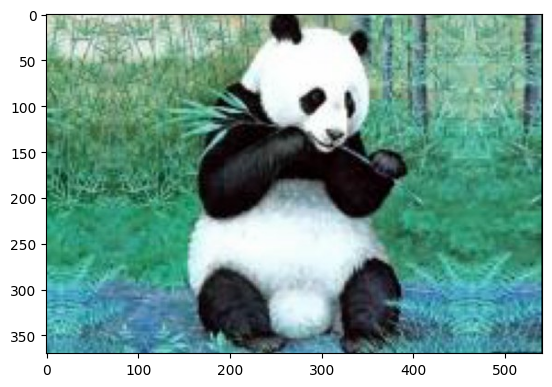

(200170, 3)

In [23]:
# Load image
image_name = 'panda'
image_path = './{}.jpg'.format(image_name)
image = cv.imread(image_path)
plt.imshow(image)
plt.show()

image_height, image_width, image_channels = image.shape
image_pixels = np.reshape(image, (-1, image_channels))
_mean = np.mean(image_pixels,axis=0,keepdims=True)
_std = np.std(image_pixels,axis=0,keepdims=True)
image_pixels = (image_pixels - _mean) / _std # Normalization
image_pixels.shape

In [24]:
COLORS = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0)
]

In [35]:
if __name__ == '__main__':
    # Load image
    image_name = 'panda'
    image_path = './{}.jpg'.format(image_name)
    image = cv.imread(image_path)
#     plt.imshow(image)
#     plt.show()

    image_height, image_width, image_channels = image.shape
    image_pixels = np.reshape(image, (-1, image_channels))
    _mean = np.mean(image_pixels,axis=0,keepdims=True)
    _std = np.std(image_pixels,axis=0,keepdims=True)
    image_pixels = (image_pixels - _mean) / _std # Normalization

    # Input number of classes
    ncomp = 4

    # Apply K-Means to find the initial weights and covariance matrices for GMM
    kmeans = KMeans(n_clusters=ncomp)
    labels = kmeans.fit_predict(image_pixels)
    initial_mus = kmeans.cluster_centers_
    initial_priors, initial_covs = [], []
    map_beliefs = np.reshape(labels, (image_height, image_width))
    segmented_map = np.zeros((image_height, image_width, 3))
    for i in range(image_height):
        for j in range(image_width):
            hard_belief = map_beliefs[i,j]
            COLORS = [(int(x[2]*255), int(x[1]*255), int(x[0]*255)) for x in initial_mus]
            segmented_map[i, j, :] = np.asarray(COLORS[hard_belief]) / 255.0
#     plt.imshow(segmented_map)
#     plt.show()

    for i in range(ncomp):
        datas = np.array([image_pixels[j, :] for j in range(len(labels)) if labels[j] == i]).T
        initial_covs.append(np.cov(datas))
        initial_priors.append(datas.shape[1] / float(len(labels)))

#     # Initialize a GMM
#     gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)

#     # EM Algorithm
#     prev_log_likelihood = None
#     for i in range(1000):
#         beliefs, log_likelihood = gmm.inference(image_pixels) # E-step
#         gmm.update(image_pixels, beliefs)   # M-step
#         print('Iteration {}: Log Likelihood = {}'.format(i+1, log_likelihood))
#         if prev_log_likelihood != None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
#             break
#         prev_log_likelihood = log_likelihood

#     # Show Result
#     beliefs, log_likelihood = gmm.inference(image_pixels)
#     map_beliefs = np.reshape(beliefs, (image_height, image_width, ncomp))
#     segmented_map = np.zeros((image_height, image_width, 3))
#     for i in range(image_height):
#         for j in range(image_width):
#             hard_belief = np.argmax(map_beliefs[i, j, :])
#             segmented_map[i,j,:] = np.asarray(COLORS[hard_belief]) / 255.0
#     plt.imshow(segmented_map)
#     plt.show()



C:\Users\pym66\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NameError: name 'initial_means' is not defined